# Simple Shopper Insights

last modified: May, 2016

author: [Raj Singh](https://developer.ibm.com/clouddataservices/author/rrsingh/)

original: https://github.com/ibm-cds-labs/open-data/blob/master/samples/shopper-insights.ipynb

## Overview

Today, an ever growing wealth of public data, e.g. census, geospatial, demographic, incident, traffic, etc., is available to fuel analytic insights when combined with corporate data. Your own data only tells you what your business is doing. With open data, you learn what the world is doing. And the combination of the two allows you to align business practices with the market.

**Simple Shopper Insights** is about democratizing big data analytics with open data and cloud-based analytics. It's a [Jupyter notebook](http://jupyter.org/) that runs best in [IBM's Spark-as-a-service](http://www.ibm.com/analytics/us/en/technology/cloud-data-services/spark-as-a-service/) that enables a Bluemix user to integrate customer sales data with US Census demographic data, and in minutes perform common analyses that once took days or weeks to complete.

This notebook goes through a complete analysis using sample data readily available on the web. But it also serves as a template for your own work with your own data. Just substitute the sample sales data with your own! 

Here are some of the insights produced in this notebook:
1. demographic characteristics of good customers
1. most important demographic characteristics in understanding product appeal
1. location of places that are like those areas currently enjoying strong sales

<a id="toc"></a>
## Table of Contents

- [Setup](#setup)
- [Census Data](#censusdata)
  - [Census data description](#censusdatadesc)
  - [Import](#censusdataimport)
- [Sales data](#salesdata)
  - [Import](#salesdataimport)
  - [Merge with Census](#salesdatamerge)
- [Insights](#insights)
- [Finding high potential zip codes](#zipfind)
- [Target zip codes](#targetregions)
- [Mapping](#mapping)
- Appendices
  - [Appendix A: Examining correlation](#correlation)
  - [Appendix B: Visualizing Customer Demograpics vs. the Nation](#viz)
  

<a id="setup"></a>
## Setup

### Python Imports
[back to top](#toc)
Import libraries and connection information to connect to Swift Object Storage on IBM Bluemix to get data from CSV text files. 

In [1]:
import os, requests, StringIO, pandas as pd, numpy as np, json, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

/Users/rajrsingh/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<a id="censusdata"></a>
## Census data
[back to top](#toc)

Census data from the 2013 US Census American Community Survey (ACS), 5-year estimates. 

Created from the "zip code tabulation area" (ZCTA) [TIGER/Line® with Selected Demographic and Economic Data product in Geodatabase format](http://www.census.gov/geo/maps-data/data/tiger-data.html). This particular version of the ACS is used for the folowing reasons:
1. 5-year estimates are the most accurate data outside of the decennial census [as explained here](http://www.census.gov/programs-surveys/acs/guidance/estimates.html).
1. 2013 is the most recent data set with 5-year estimates
1. TIGER/Line® gives you the geographic boundaries of the zip codes so you can perform spatial analyses
1. This data set is smaller than the full Census, but still has the important income, education, race, age and occupation demographics we want to use.

If you want to do this yourself, [this article](https://developer.ibm.com/clouddataservices/2015/09/08/census-open-data-on-ibm-cloud/) explains how to get a CSV out of that format.

### Accessing Census files

Access the files mentioned here via the [IBM Analytics Exchange](https://console.ng.bluemix.net/data/exchange/). You can get your free, individual "API key" on each data set's detail page:
 
- [Income](https://console.ng.bluemix.net/data/exchange/public/e/united-states-demographic-measures-income)
- [Age](https://console.ng.bluemix.net/data/exchange/public/e/united-states-demographic-measures-age)
- [Education](https://console.ng.bluemix.net/data/exchange/public/e/united-states-demographic-measures-education)
- [Race](https://console.ng.bluemix.net/data/exchange/public/e/united-states-demographic-measures-race)

After getting your API key (your personal URL for the data file), in this script replace, for example, `os.environ['AE_KEY_AGE']` with your URL for the Age data CSV file.

<a id="censusdatadesc"></a>
### Census data description

Here are the data fields we will use from the Census

```
GEOID: Zip code
```

### Income
```
B19049e1: Median household income
```

#### Age
```
B01002e1: Median age
```

#### Educational attainment (population >= 25 years old)
```
B15003e1: Total population
B15003e2: No schooling completed
B15003e3: Nursery school
B15003e4 to B15003e16: Kindergarten to 12th grade
B15003e17: Regular high school diploma
B15003e18: GED or alternative
B15003e19: Some college, < 1 year
B15003e20: Some college, 1 or more years, no degree
B15003e21: Associates degree
B15003e22: Bachelors degree
B15003e23: Masters degree
B15003e24: Professional degree
B15003e25: Doctorate degree
```

#### Race
```
B02001e1: Total population
B02001e2: White alone
B02001e3: Black or African American alone
B02001e4: American Indian and Alaska Native alone
B02001e5: Asian alone
B02001e6: Native Hawaiian and Other Pacific Islander alone
B02001e7: Some other race alone
B02001e8: Two or more races
B03001e3: Hispanic or Latino: Total population
```

<a id="censusdataimport"></a>
### Import Census data

Group educational attainment into 4 major categories, and normalize by making it a percentage of the zip code's population

#### Age

In [2]:
census_age_df = pd.read_csv( os.environ['AE_KEY_AGE'], usecols=['GEOID','B01002e1'] )
census_age_df.columns = ['GEOID','AGE']

#### Income

In [3]:
census_income_df = pd.read_csv( os.environ['AE_KEY_INCOME'], usecols=['GEOID','B19049e1'] )
census_income_df.columns = ['GEOID','INCOME']

#### Race

In [4]:
census_race_df = pd.read_csv(os.environ['AE_KEY_RACE'], 
                             usecols=['GEOID','B02001e1','B02001e2','B02001e3','B02001e4',
                                 'B02001e5','B02001e6','B02001e7','B02001e8','B03001e3'])

census_race_df['WHITE'] = census_race_df['B02001e2']/census_race_df['B02001e1']
census_race_df['BLACK'] = census_race_df['B02001e3']/census_race_df['B02001e1']
census_race_df['NATAMER'] = census_race_df['B02001e4']/census_race_df['B02001e1']
census_race_df['ASIAN'] = census_race_df['B02001e5']/census_race_df['B02001e1']
census_race_df['PACISL'] = census_race_df['B02001e6']/census_race_df['B02001e1']
census_race_df['OTHERRACE'] = census_race_df['B02001e7']/census_race_df['B02001e1']
census_race_df['MULTIRACE'] = census_race_df['B02001e8']/census_race_df['B02001e1']
census_race_df['HISPLAT'] = census_race_df['B03001e3']/census_race_df['B02001e1']

census_race_df.drop(['B02001e1','B02001e2','B02001e3','B02001e4','B02001e5','B02001e6','B02001e7','B02001e8','B03001e3'],inplace=True,axis=1)

#### Education

In [5]:
census_edu_df = pd.read_csv( os.environ['AE_KEY_EDUCATION'], 
                        usecols=['GEOID','B15003e1','B15003e2','B15003e3','B15003e4','B15003e5','B15003e6',
                                 'B15003e7','B15003e8','B15003e9','B15003e10','B15003e11','B15003e12','B15003e13',
                                 'B15003e14','B15003e15','B15003e16','B15003e17','B15003e18','B15003e19','B15003e20',
                                 'B15003e21','B15003e22','B15003e23','B15003e24','B15003e25'])

census_edu_df['NOHSDIP'] = (census_edu_df['B15003e2']+census_edu_df['B15003e3']+census_edu_df['B15003e4']+census_edu_df['B15003e5']+census_edu_df['B15003e6']+census_edu_df['B15003e7']+census_edu_df['B15003e8']+census_edu_df['B15003e9']+census_edu_df['B15003e10']+census_edu_df['B15003e11']+census_edu_df['B15003e12']+census_edu_df['B15003e13']+census_edu_df['B15003e14']+census_edu_df['B15003e15']+census_edu_df['B15003e16'])/census_edu_df['B15003e1']

census_edu_df['HSDIPSOMECOL'] = (census_edu_df['B15003e17']+census_edu_df['B15003e18']+census_edu_df['B15003e19']+census_edu_df['B15003e20']+census_edu_df['B15003e21'])/census_edu_df['B15003e1']

census_edu_df['BA'] = census_edu_df['B15003e22']/census_edu_df['B15003e1']

census_edu_df['GRAD'] = (census_edu_df['B15003e23']+census_edu_df['B15003e24']+census_edu_df['B15003e25'])/census_edu_df['B15003e1']

census_edu_df['POPULATION'] = census_edu_df['B15003e1']

census_edu_df.drop(['B15003e1','B15003e2','B15003e3','B15003e4','B15003e5','B15003e6',
                    'B15003e7','B15003e8','B15003e9','B15003e10','B15003e11','B15003e12','B15003e13',
                    'B15003e14','B15003e15','B15003e16','B15003e17','B15003e18','B15003e19','B15003e20',
                    'B15003e21','B15003e22','B15003e23','B15003e24','B15003e25'],inplace=True,axis=1)

In [6]:
census_income_age_df = census_income_df.merge(census_age_df, on='GEOID')
census_income_age_race_df = census_income_age_df.merge(census_race_df, on='GEOID')
census_df = census_income_age_race_df.merge(census_edu_df, on='GEOID')

census_df.set_index('GEOID',inplace=True)
census_df.sample(5)

INCOME   AGE     WHITE     BLACK   NATAMER     ASIAN    PACISL  \
GEOID                                                                          
86000US36584   24250  37.1  0.569704  0.297475  0.061471  0.000000  0.000000   
86000US64075   55746  36.2  0.980485  0.006057  0.000000  0.001094  0.000925   
86000US04471   28250  55.0  0.974359  0.003945  0.000000  0.017751  0.000000   
86000US37862   35895  39.1  0.927299  0.013939  0.005922  0.020225  0.000410   
86000US65230   53109  47.5  0.833083  0.106767  0.000000  0.000000  0.000000   

              OTHERRACE  MULTIRACE   HISPLAT   NOHSDIP  HSDIPSOMECOL  \
GEOID                                                                  
86000US36584   0.054885   0.016465  0.108672  0.266332      0.648241   
86000US64075   0.002860   0.008580  0.079240  0.104852      0.726011   
86000US04471   0.000000   0.003945  0.001972  0.087065      0.753731   
86000US37862   0.026192   0.006013  0.119984  0.195993      0.635074   
86000US65230   0.000000   0.060150  0.000000  0.188605      0.636542   

                    BA      GRAD  POPULATION  
GEOID                                         
86000US36584  0.065327  0.020101         597  
86000US64075  0.110647  0.058491        7420  
86000US04471  0.109453  0.049751         402  
86000US37862  0.111396  0.057537       15225  
86000US65230  0.115914  0.058939         509

<a id="salesdata"></a>
## Sales data


<a id="salesdataimport"></a>
### Import sample sales data set

Here we bring in a relatively small sample sales data set. There are only about 400 U.S. sales for the product we are interested in -- "Product1". But this is good enough to illustrate the analysis. 

If you were to do this yourself with your own sales data, your data should organized as follows:
1. there should be sales in the U.S. (since we're analyzing it against U.S. Census data)
1. each row should represent a unique sale
1. the data set should contain columns for zip code, price, product ID and Country name
1. the data set should be in a CSV text file format


In [7]:
country = 'United States'
product = 'Product1'

# import the CSV file
raw_data = "https://github.com/ibm-cds-labs/open-data/raw/master/salesjan2009/salesjan2009.csv.gz"

# create a data frame with just the columns we need
sales_df = pd.read_csv(raw_data, compression='gzip', dtype={"US Zip": np.str}, 
                       usecols=['Product','US Zip','Country'])

# just get US sales for a single product
sales_df = sales_df[ (sales_df.Product == product) 
                      & (sales_df.Country == country)]

# make the zip code format match the zip code format in the census data
sales_df['GEOID'] = "86000US" + sales_df['US Zip']

# drop columns we don't need anymore
sales_df.drop(['Product','Country','US Zip'],inplace=True,axis=1)

In [8]:
sales_counts = sales_df['GEOID'].value_counts()
sales_counts.name = 'Sales'
sales_counts.describe()

count    306.000000
mean       1.307190
std        0.866733
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: Sales, dtype: float64

<a id="salesdatamerge"></a>
### Merge sales to Census
[back to top](#toc)

In [9]:
saleszips = census_df.join(sales_counts, how='right')
saleszips['Zip'] = saleszips.index
saleszips.describe(percentiles=[0.4,0.5,0.6])

INCOME         AGE       WHITE       BLACK     NATAMER  \
count     304.000000  304.000000  304.000000  304.000000  304.000000   
mean    76178.167763   39.015132    0.760876    0.093561    0.005064   
std     36094.736528    6.057036    0.193980    0.144929    0.012988   
min     16069.000000   21.800000    0.095601    0.000000    0.000000   
40%     62186.000000   37.400000    0.783673    0.025167    0.001416   
50%     69855.500000   38.650000    0.819666    0.035619    0.002246   
60%     79873.600000   40.600000    0.857119    0.054711    0.002938   
max    216037.000000   68.300000    0.994135    0.767693    0.136069   

            ASIAN      PACISL   OTHERRACE   MULTIRACE     HISPLAT     NOHSDIP  \
count  304.000000  304.000000  304.000000  304.000000  304.000000  304.000000   
mean     0.072316    0.002496    0.036198    0.029490    0.134404    0.100072   
std      0.090579    0.011741    0.056148    0.031175    0.151961    0.083413   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
40%      0.027078    0.000000    0.011289    0.020066    0.060033    0.058791   
50%      0.038763    0.000000    0.015675    0.023534    0.076052    0.074362   
60%      0.056001    0.000132    0.022228    0.027695    0.104562    0.092572   
max      0.488290    0.115780    0.385442    0.271421    0.887213    0.553417   

       HSDIPSOMECOL          BA        GRAD    POPULATION       Sales  
count    304.000000  304.000000  304.000000    305.000000  306.000000  
mean       0.472995    0.246166    0.180768  17508.301639    1.307190  
std        0.148536    0.093341    0.115888  11111.128358    0.866733  
min        0.040559    0.000000    0.010708      0.000000    1.000000  
40%        0.436068    0.220465    0.124059  13572.800000    1.000000  
50%        0.478094    0.247006    0.159859  16488.000000    1.000000  
60%        0.531858    0.279242    0.192510  19351.800000    1.000000  
max        0.769231    0.440627    0.656643  65117.000000    9.000000

### Identify sales zips with strongest correlation to customers
[back to top](#toc)

e.g. zips with at least 2 sales - or the top 75% of zips with sales

In [10]:
# 25% threshold is 1, so select zips with sales > 1
highsaleszips = saleszips[ ( saleszips.Sales > 1)]
highsaleszipssum_df = highsaleszips.describe(percentiles=[.40,.50,.60])
highsaleszipssum_df = highsaleszipssum_df.drop(highsaleszipssum_df.index[[0,2]])
highsaleszipssum_df.drop(['Sales'],inplace=True,axis=1)
highsaleszipssum_df

INCOME    AGE     WHITE     BLACK   NATAMER     ASIAN    PACISL  \
mean   76031.980769  37.85  0.699061  0.123149  0.006745  0.089312  0.003743   
min    22401.000000  29.90  0.095601  0.003826  0.000000  0.000000  0.000000   
40%    56963.600000  35.58  0.725771  0.055825  0.001435  0.037337  0.000000   
50%    69728.500000  37.80  0.766824  0.080367  0.002208  0.054002  0.000000   
60%    81812.000000  39.26  0.796342  0.101325  0.002779  0.072390  0.000265   
max   216037.000000  55.60  0.989341  0.760590  0.136069  0.488290  0.104259   

      OTHERRACE  MULTIRACE   HISPLAT   NOHSDIP  HSDIPSOMECOL        BA  \
mean   0.045753   0.032236  0.171723  0.116458      0.416471  0.261879   
min    0.000000   0.000000  0.000000  0.000000      0.040559  0.000000   
40%    0.018347   0.021595  0.077678  0.064051      0.396659  0.239548   
50%    0.021491   0.027897  0.104359  0.077361      0.424456  0.274037   
60%    0.025422   0.030893  0.123695  0.097105      0.450315  0.307510   
max    0.384390   0.191157  0.887213  0.417073      0.769231  0.440627   

          GRAD    POPULATION  
mean  0.205191  17283.132075  
min   0.016456      0.000000  
40%   0.156830  12456.400000  
50%   0.178124  16354.000000  
60%   0.209332  18323.800000  
max   0.656643  65117.000000

<a id="insights"></a>
## Insights

Let's create a table that shows the difference between the country as a whole versus zip codes with sales. This allows us to easily identify the major characteristics that define our customer base.

In [11]:
summary_df = census_df.describe(percentiles=[0.4,0.5,0.6])
summary_df = summary_df.drop(summary_df.index[[0,2]])
summary_df

INCOME        AGE     WHITE     BLACK   NATAMER     ASIAN  \
mean   52112.585863  41.495351  0.841515  0.076411  0.017566  0.019763   
min     2499.000000   4.000000  0.000000  0.000000  0.000000  0.000000   
40%    43864.000000  39.400000  0.888687  0.003023  0.000000  0.000000   
50%    47778.000000  41.100000  0.929005  0.008680  0.000930  0.002520   
60%    52031.000000  42.900000  0.954310  0.019099  0.002237  0.005837   
max   250001.000000  91.500000  1.000000  1.000000  1.000000  1.000000   

        PACISL  OTHERRACE  MULTIRACE   HISPLAT   NOHSDIP  HSDIPSOMECOL  \
mean  0.001062   0.021783   0.021899  0.084829  0.142982      0.635888   
min   0.000000   0.000000   0.000000  0.000000  0.000000      0.000000   
40%   0.000000   0.000000   0.009633  0.016256  0.098551      0.629885   
50%   0.000000   0.002613   0.013994  0.026227  0.118819      0.658076   
60%   0.000000   0.006331   0.018782  0.040488  0.143008      0.683938   
max   0.610088   1.000000   1.000000  1.000000  1.000000      1.000000   

            BA      GRAD    POPULATION  
mean  0.141745  0.079385   6262.068235  
min   0.000000  0.000000      0.000000  
40%   0.101979  0.044529   1121.000000  
50%   0.120989  0.055047   1885.000000  
60%   0.142688  0.067751   3337.800000  
max   1.000000  1.000000  73169.000000

In [12]:
salesdiff_df = highsaleszipssum_df.sub(summary_df)
salesdiff_df

INCOME        AGE     WHITE     BLACK   NATAMER     ASIAN  \
mean  23919.394907  -3.645351 -0.142454  0.046738 -0.010821  0.069549   
min   19902.000000  25.900000  0.095601  0.003826  0.000000  0.000000   
40%   13099.600000  -3.820000 -0.162916  0.052802  0.001435  0.037337   
50%   21950.500000  -3.300000 -0.162181  0.071687  0.001277  0.051482   
60%   29781.000000  -3.640000 -0.157968  0.082226  0.000542  0.066553   
max  -33964.000000 -35.900000 -0.010659 -0.239410 -0.863931 -0.511710   

        PACISL  OTHERRACE  MULTIRACE   HISPLAT   NOHSDIP  HSDIPSOMECOL  \
mean  0.002680   0.023970   0.010337  0.086894 -0.026523     -0.219417   
min   0.000000   0.000000   0.000000  0.000000  0.000000      0.040559   
40%   0.000000   0.018347   0.011962  0.061422 -0.034500     -0.233226   
50%   0.000000   0.018878   0.013903  0.078132 -0.041458     -0.233619   
60%   0.000265   0.019091   0.012111  0.083207 -0.045903     -0.233622   
max  -0.505829  -0.615610  -0.808843 -0.112787 -0.582927     -0.230769   

            BA      GRAD    POPULATION  
mean  0.120134  0.125806  11021.063841  
min   0.000000  0.016456      0.000000  
40%   0.137569  0.112301  11335.400000  
50%   0.153049  0.123076  14469.000000  
60%   0.164821  0.141581  14986.000000  
max  -0.559373 -0.343357  -8052.000000

<a id="summary"></a>
### Here's what this table shows us.

#### Incomes are much higher
Median household income overall is about $22,000 higher than the country as a whole, which is **very** significant as that represents a nearly 50% increase in income in these zip codes we sell to.

#### Education is greater
The percentage of people with high school diplomas but no college degree is almost 24% lower in our sales zips, and that is compensated by a much greater number of college grads (16% higher) and people with graduate degrees of some sort (12% higher). 

#### People are a little younger
Males and females are about 3 1/2 years younger in our zip codes than in the country as a whole.


#### White population is lower
The white population is lower, and there is a corresponding higher number of other races.



<a id="zipfind"></a>
## Finding high potential zip codes

Here we take the variables we found to best explain the population of sales areas, and we look for other zip codes whose demographic characteristics for those variables are within 10 percentage points of the median.


In [13]:
censusgood_df = census_df [
    ( census_df.INCOME > highsaleszipssum_df.loc['40%','INCOME'] )
    & ( census_df.INCOME < highsaleszipssum_df.loc['60%','INCOME'] )
    & ( census_df.AGE > highsaleszipssum_df.loc['40%','AGE'] )
    & ( census_df.AGE < highsaleszipssum_df.loc['60%','AGE'] )
    & ( census_df.BA > highsaleszipssum_df.loc['40%','BA'] )
    & ( census_df.BA < highsaleszipssum_df.loc['60%','BA'] )
    & ( census_df.WHITE > highsaleszipssum_df.loc['40%','WHITE'] )
    & ( census_df.WHITE < highsaleszipssum_df.loc['60%','WHITE'] )
    ]
censusgood_df.describe()

INCOME        AGE      WHITE      BLACK    NATAMER      ASIAN  \
count     38.000000  38.000000  38.000000  38.000000  38.000000  38.000000   
mean   70446.605263  37.463158   0.768633   0.085920   0.005015   0.076523   
std     6742.784887   1.088371   0.016332   0.053489   0.006879   0.045081   
min    56989.000000  35.600000   0.734561   0.004204   0.000000   0.010085   
25%    65683.000000  36.700000   0.758709   0.031806   0.001363   0.035986   
50%    71264.500000  37.500000   0.769553   0.081308   0.002594   0.069844   
75%    75855.750000  38.275000   0.782585   0.139436   0.005690   0.114887   
max    81570.000000  39.200000   0.795636   0.194423   0.030930   0.174340   

          PACISL  OTHERRACE  MULTIRACE    HISPLAT    NOHSDIP  HSDIPSOMECOL  \
count  38.000000  38.000000  38.000000  38.000000  38.000000     38.000000   
mean    0.000892   0.034307   0.028710   0.129219   0.075874      0.480398   
std     0.001449   0.033679   0.013181   0.103808   0.040426      0.071450   
min     0.000000   0.001946   0.005835   0.003232   0.026752      0.284136   
25%     0.000000   0.012179   0.021300   0.044803   0.054869      0.445958   
50%     0.000169   0.026639   0.023845   0.103528   0.059818      0.495970   
75%     0.001007   0.040903   0.034961   0.182670   0.083850      0.521748   
max     0.005354   0.166911   0.056916   0.400737   0.230875      0.591778   

              BA       GRAD    POPULATION  
count  38.000000  38.000000     38.000000  
mean    0.270187   0.173540  23031.210526  
std     0.021725   0.067237   9070.647905  
min     0.240809   0.095628   8661.000000  
25%     0.252169   0.134817  17189.000000  
50%     0.266366   0.152044  22907.500000  
75%     0.288145   0.188011  27507.250000  
max     0.307421   0.399583  52815.000000

<a id="targetregions"></a>
### Target regions

Here we list the matching zip codes. From this point you could use this list in a variety of ways. Here are some ideas: 
- Guidance for where to spend marketing dollars
- Filter existing direct mail lists to target those most likely to buy
- Guidance on where to build retail outlets, or if you're a wholesaler, where you want to get your products retailed.


In [14]:
censusgood_df.index.tolist()

['86000US06119',
 '86000US07012',
 '86000US11209',
 '86000US15220',
 '86000US21209',
 '86000US27511',
 '86000US28075',
 '86000US29414',
 '86000US30101',
 '86000US30152',
 '86000US30265',
 '86000US32819',
 '86000US33071',
 '86000US33324',
 '86000US33414',
 '86000US43230',
 '86000US48083',
 '86000US48103',
 '86000US48187',
 '86000US55116',
 '86000US55337',
 '86000US55406',
 '86000US60070',
 '86000US60188',
 '86000US60542',
 '86000US61615',
 '86000US61822',
 '86000US62269',
 '86000US73170',
 '86000US75229',
 '86000US85044',
 '86000US91504',
 '86000US91505',
 '86000US92373',
 '86000US93940',
 '86000US94061',
 '86000US97086',
 '86000US98011']

### Update data tables in CartoDB

In [15]:
#!pip install --user cartodb
# Set up cartodb module for use
from cartodb import CartoDBAPIKey, CartoDBException
API_KEY = os.environ['CARTODB_APIKEY']
CARTODB_ACCOUNT = os.environ['CARTODB_ACCOUNT']
cl = CartoDBAPIKey(API_KEY, CARTODB_ACCOUNT)

#### Update Sales table in CartoDB

In [16]:
# output good Census zips to a list
ziplist = highsaleszips.index.tolist()

In [18]:
# generate PostgreSQL INSERT statements for CartoDB
insertsql = ';'.join(map(lambda x: "INSERT INTO highsaleszips(zipcode) VALUES ('%s')" %x, ziplist))

In [19]:
# update sales table
try:
    print(cl.sql('delete from highsaleszips'))
    print(cl.sql(insertsql))
except CartoDBException as e:
    print("some error ocurred", e)

{u'fields': {}, u'rows': [], u'total_rows': 53, u'time': 0.071}
{u'fields': {}, u'rows': [], u'total_rows': 1, u'time': 0.358}


#### Update prospective zip codes  in CartoDB

In [20]:
# output good Census zips to a list
ziplist = censusgood_df.index.tolist()

In [21]:
# generate PostgreSQL INSERT statements for CartoDB
insertsql = ';'.join(map(lambda x: "INSERT INTO prospectzips(zipcode) VALUES ('%s')" %x, ziplist))

In [22]:
try:
    print(cl.sql('delete from prospectzips'))
    print(cl.sql(insertsql))
except CartoDBException as e:
    print("some error ocurred", e)

{u'fields': {}, u'rows': [], u'total_rows': 38, u'time': 0.016}
{u'fields': {}, u'rows': [], u'total_rows': 1, u'time': 0.21}


<a id="mapping"></a>
## Display the dynamic map

In [23]:
%%javascript
element.append('<link rel="stylesheet" href="http://libs.cartocdn.com/cartodb.js/v3/3.15/themes/css/cartodb.css" />');
element.append('<h2>High value target sales areas</h2>');
element.append('<div id="map" style="height:450px;width:768px;padding:0;margin:0"></div>');

require.config({
  paths: {
      cartodblib: '//libs.cartocdn.com/cartodb.js/v3/3.15/cartodb'
  }
});

var main = function() {
  cartodb.createVis('map', 'https://ibmanalytics.cartodb.com/u/ibm/api/v2/viz/2bd6ea76-9f7f-11e5-a024-0e674067d321/viz.json', {
      shareable: true,title: true,description: true,search: true,tiles_loader: true,
      center_lat: 40, center_lon: -100, zoom: 3
  })
  .done(function(vis, layers) {
    // layer 0 is the base layer, layer 1 is cartodb layer
    //layers[1].setInteraction(true);
    //layers[1].on('featureOver', function(e, latlng, pos, data) {
    //  cartodb.log.log(e, latlng, pos, data);
    //});
    //var map = vis.getNativeMap(); // get the native map to work with it
  })
  .error(function(err) {
    console.log(err);
  });
}

require(['cartodblib'], main);

<IPython.core.display.Javascript object>

# The end

# Appendices

<a id="correlation"></a>
## Appendix A: Examining correlation

In this section, we take a quick look at the correlation coefficients of many of our variables of interest to make sure it's worth looking at each one separately. This function computes the [Pearson product-moment correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), which looks at two variables and computes a number between -1 and 1, where -1 is perfect negative correlation, 1 is perfect positive correlation, and 0 is no correlation. 

None of our variables of interest have a particularly strong correlation with each other (except for the obvious ones like income with bachelor's (BA) or graduate degree (GRAD)), so we can proceed with analysis knowing that it's worth looking at all of them. 

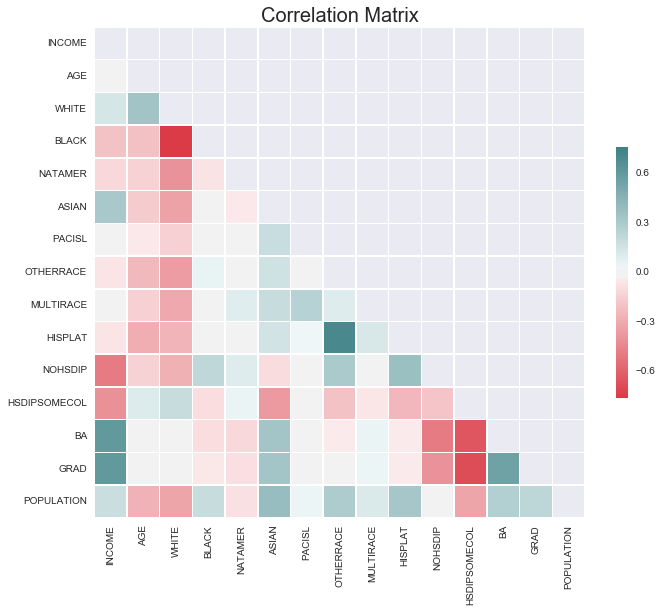

In [23]:
corr = census_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 200, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Correlation Matrix', size=20)
plt.show()

<a id="viz"></a>
## Appendix B: Visualizing Customer Demograpics vs. the Nation

In [24]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)
highzipaxlabel = '# of zips - zips with high sales'
nationalaxlabel = '# of zips - nation'

### Income

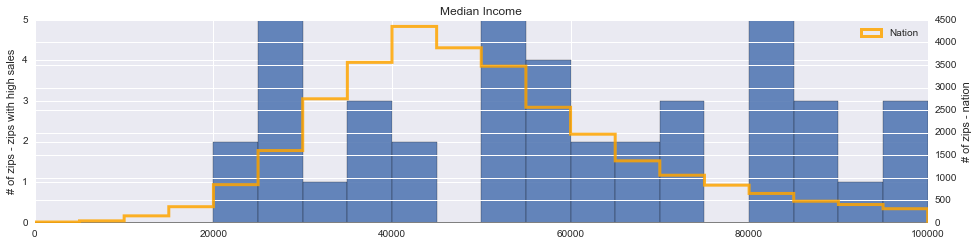

In [25]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0.0,100000))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['INCOME'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['INCOME'], label='Nation', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Median Income")
plt.legend(loc='upper right')
plt.show()

## Age

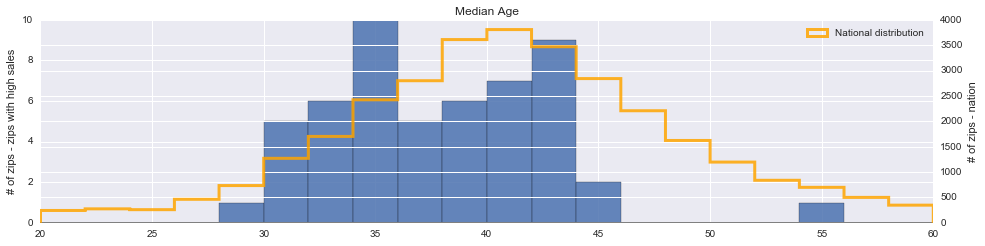

In [26]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(20,60))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['AGE'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['AGE'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Median Age")
plt.legend(loc='upper right')
plt.show()

## No High School diploma

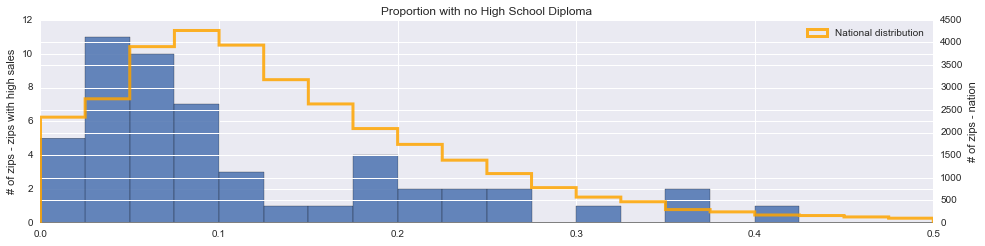

In [27]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0,0.5))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['NOHSDIP'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['NOHSDIP'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Proportion with no High School Diploma")
plt.legend(loc='upper right')
plt.show()

## Bachelor's degree

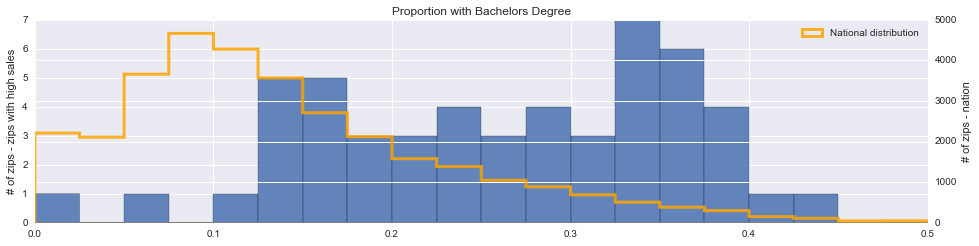

In [28]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0,0.5))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['BA'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['BA'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Proportion with Bachelors Degree")
plt.legend(loc='upper right')
plt.show()

## White race

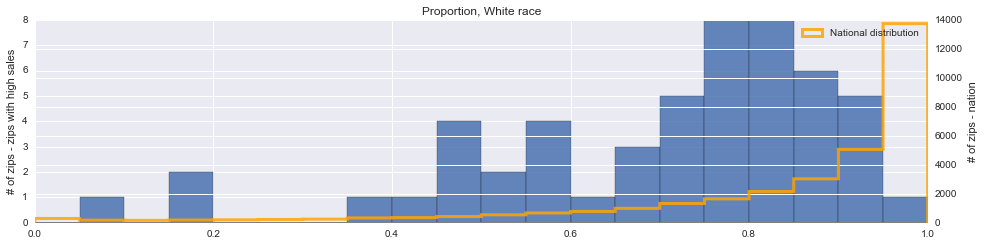

In [29]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0,1))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['WHITE'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['WHITE'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Proportion, White race")
plt.legend(loc='upper right')
plt.show()

## Black race

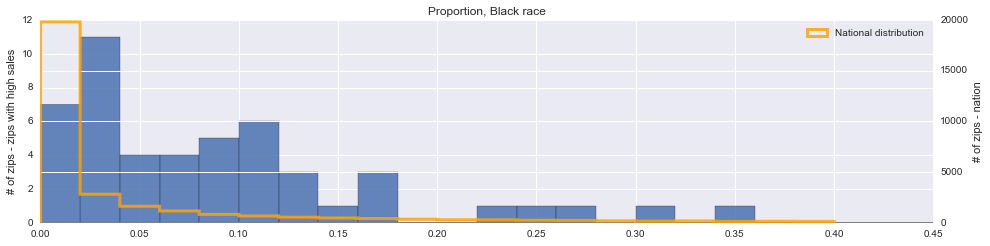

In [30]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0,0.4))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['BLACK'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['BLACK'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Proportion, Black race")
plt.legend(loc='upper right')
plt.show()

## Asian race

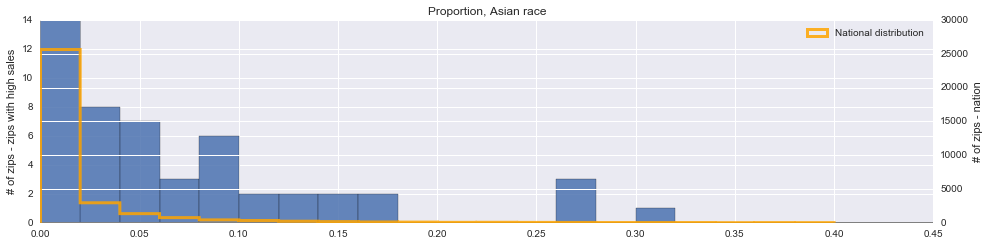

In [31]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0,0.4))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['ASIAN'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['ASIAN'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Proportion, Asian race")
plt.legend(loc='upper right')
plt.show()

## Hispanic or Latino

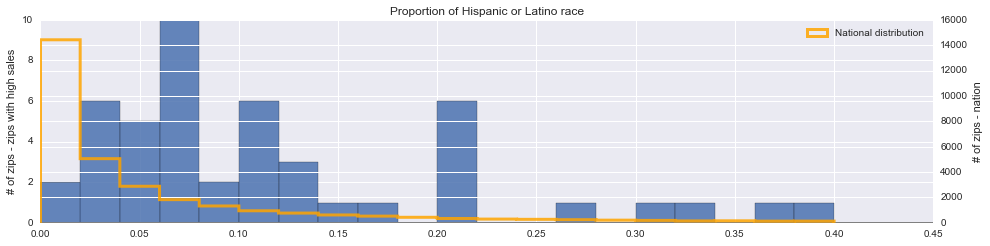

In [32]:
fig = plt.figure()
common_params = dict(bins=20, alpha=0.85, range=(0,0.4))

ax = fig.add_subplot(211)
plt.hist(highsaleszips['HISPLAT'], label='Sales Zips', **common_params)
ax.set_ylabel(highzipaxlabel)
ax.axhline(0, color='gray', lw=2)

ax_national = ax.twinx()
ax_national.set_ylabel(nationalaxlabel)
ax_national.hist(census_df['HISPLAT'], label='National distribution', histtype='step', linewidth=3, color='orange', **common_params)

plt.title("Proportion of Hispanic or Latino race")
plt.legend(loc='upper right')
plt.show()

## Major racial groups for zip codes in which we have sales

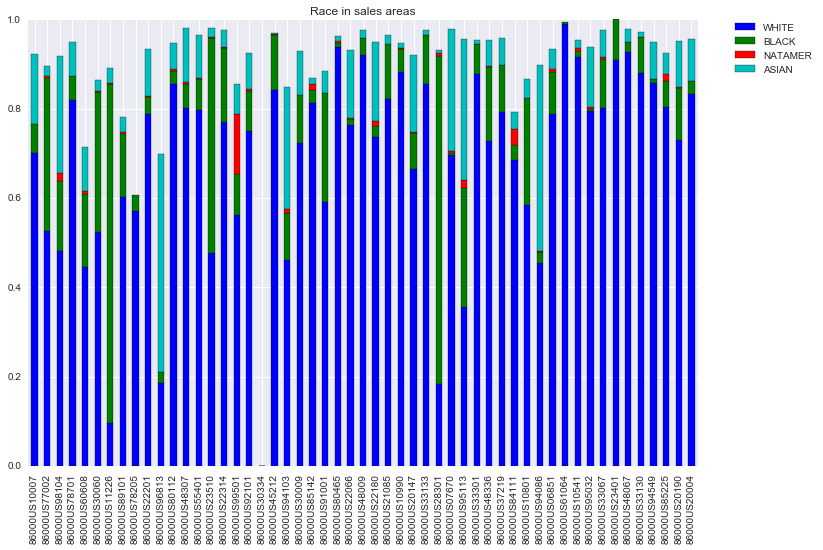

In [33]:
highsaleszips.loc[:,'WHITE':'ASIAN'].plot(kind='bar', stacked=True, figsize=(12,8), title='Race in sales areas')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)